In [1]:
import tweepy
import pandas as pd
from collections import namedtuple, Counter
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
# set up Twitter credentials using tweepy 

auth = tweepy.OAuthHandler('UEALJgD2o5lwpOeAeNhb9ceWX', 'JqB4i0TIqRizGtp97BovQN5iQDgA5BpF5tHHL0nZkUEANjxJuV')
auth.set_access_token('732602583689367552-KeUxTRNYO2XwFux13Tp1yLoKyylMyO7', '0WWtEXmjOV1g732CBPs9Te8xQa7VKuSIBP9A0J4dxm1mL')

api = tweepy.API(auth)

In [3]:
# use named tuples to keep info of interest for each tweet; keep urls to remove from text later

Tweet = namedtuple('Tweet', ['text', 'tags', 'cited', 'urls', 'author'])

In [4]:
# utility functions to collect info of interest

def get_hashtags(tweet):
    tags = []
    if len(tweet['entities']['hashtags']) > 0:
        for tag in tweet['entities']['hashtags']:
            tags.append(tag['text'])
    return tags

def get_citations(tweet):
    citations = []
    if len(tweet['entities']['user_mentions']) > 0:
        for mention in tweet['entities']['user_mentions']:
            citations.append(mention['screen_name'])
    return citations

def get_urls(tweet):
    urls = []
    if len(tweet['entities']['urls']) > 0:
        for url in tweet['entities']['urls']:
            urls.append(url['url'])
    return urls
           

In [42]:
# pull in tweets for each influencer listed in influencers.txt and process most recent 500 that are not retweets
# store as lists in a dict with the influencer handles as keys 

all_tweets = {}
with open('influencers.txt', 'r') as names:
    for raw_name in names:
        name = raw_name.strip()
        tweets = tweepy.Cursor(api.user_timeline, id=name, tweet_mode='extended').items(800)
        keepers = [tweet._json for tweet in tweets if 'retweeted_status' not in tweet._json]
        all_tweets[name] = [Tweet(tweet['full_text'], get_hashtags(tweet), get_citations(tweet), get_urls(tweet),
                                  name) for tweet in keepers[:500]]    

names = all_tweets.keys()



In [13]:
# also get the description each person uses

descriptions = {}
for name in names:
    descriptions[name] = api.get_user(name)._json['description']

In [59]:
# save data in case kernel hangs or is stopped

with open('twitter_data.pydat', 'wb') as datafile:
    pickle.dump(all_tweets, datafile)

with open('twitter_descriptions.pydat', 'wb') as datafile:
    pickle.dump(all_tweets, datafile)

In [16]:
# create dict of Counters for the hashtags used by each person

all_tags = {}
for name in names:
    tags = [tweet.tags for tweet in all_tweets[name]]
    all_tags[name] = Counter(list(itertools.chain(*tags)))

In [17]:
# create dict of Counters for the mentions made by each person

all_mentions = {}
for name in names:
    mentions = [tweet.cited for tweet in all_tweets[name]]
    all_mentions[name] = Counter(list(itertools.chain(*mentions)))

In [18]:
# create Counter for all the hashtags used

tags = Counter()
for name in names:
    tags += all_tags[name]

In [20]:
len(list(tags))

1643

In [21]:
# collect all hashtags used by more than one influencer for use as features
# should have done this with the hashtags too

tag_features = [tag for tag in list(tags.keys()) if sum([0 if all_tags[name][tag] == 0 else 1 for name in names]) > 1]
len(tag_features)

288

In [22]:
# create Counter for all the mentions made

mentions = Counter()
for name in names:
    mentions += all_mentions[name]

In [23]:
len(list(mentions))

2784

In [24]:
# collect all mentions made by more than one influencer for use as features

mention_features = [mention for mention in list(mentions.keys()) if sum([0 if all_mentions[name][mention] == 0 else 1
                                                                         for name in names]) > 1]
len(mention_features)

345

In [25]:
# find duplicates between tags and mentions

duplicates = list(set(tag_features) & set(mention_features))
len(duplicates)

10

In [26]:
# remove from mentions since there are more of them
# Note: this turned out to be unnecssary because tokenization split off the '#' but not the '@'

mention_features = [mention for mention in mention_features if mention not in duplicates]
len(mention_features)

335

In [27]:
# create feature vectors comprising the counts for each tag and mention feature

entities = pd.DataFrame(index=names, columns=(tag_features + mention_features))
for name in names:
    for tag in tag_features:
        entities.loc[name, tag] = all_tags[name][tag]
    for mention in mention_features:
        entities.loc[name, mention] = all_tags[name][mention]

In [28]:
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, DBSCAN
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [29]:
# normalize the features and perform a 2-component PCA analysis to use for graphing

normed_ents = normalize(entities)

In [30]:
ents_pca = PCA(2).fit(normed_ents)
ents_pca.explained_variance_ratio_

array([ 0.28006677,  0.15739239])

### Try basic mean shift clustering

In [31]:
ms = MeanShift()
ms.fit(normed_ents)
ms.labels_

array([0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 3, 4])

Mean shift did not produce usable results, merely clustering all the authors together except for four clusters of one person each.

### Try k-means clustering

In [32]:
# using silhouette scores over 1,000 runs to find the optimal number of clusters, then the best clusters

clusters = []
for _ in range(1000):
    best_score = 0
    num_labels = 0
    for num_clusters in range(2, 7):
        km = KMeans(num_clusters)
        km.fit(normed_ents)
        sil_score = silhouette_score(normed_ents, km.labels_)
        if sil_score > best_score:
            best_score = sil_score
            num_labels = len(np.unique(km.labels_))
    clusters.append(num_labels)

optimal_num_clusters = Counter(clusters).most_common(1)[0][0]
print('The optimal number of clusters is {}'.format(optimal_num_clusters))
      
best_labels = []
best_score = 0

for _ in range(1000):
    km = KMeans(optimal_num_clusters)
    km.fit(normed_ents)
    sil_score = silhouette_score(normed_ents, km.labels_)
    if sil_score > best_score:
        best_score = sil_score
        best_labels = km.labels_

for i in range(optimal_num_clusters):
    print('Cluster {} comprises {}'.format(i, [name for ix, name in enumerate(names) if best_labels[ix] == i]))

The optimal number of clusters is 2
Cluster 0 comprises ['AndrewYNg', 'mrogati', 'analyticbridge', 'naval', 'hmason', 'EvanSinar']
Cluster 1 comprises ['KirkDBorne', 'Ronald_vanLoon', 'craigbrownphd', 'bobehayes', 'BernardMarr', 'BigDataGal', 'data_nerd', 'kdnuggets', 'tamaradull']


In [34]:
Counter(clusters).most_common()

[(2, 631), (6, 192), (4, 76), (3, 53), (5, 48)]

The algorithm generated one cluster of authors with very few hashtags and mentions, and another comprising everyone else. This is a valid but not very sophisticated breakdown. The only really interesting result is that one author with a relatively high number of tags and mentions (EvanSinar, with 665) was put in the group with low numbers. Apparently he had few of these entities in common with others, resulting in low similarity scores as did authors with few entities.

In [35]:
for name in names:
    print('{:15}: {} entities'.format(name, entities.loc[name].sum()))

KirkDBorne     : 2493 entities
Ronald_vanLoon : 4092 entities
craigbrownphd  : 563 entities
bobehayes      : 1346 entities
BernardMarr    : 953 entities
BigDataGal     : 1273 entities
AndrewYNg      : 6 entities
mrogati        : 4 entities
data_nerd      : 147 entities
kdnuggets      : 265 entities
analyticbridge : 0 entities
naval          : 0 entities
tamaradull     : 573 entities
hmason         : 5 entities
EvanSinar      : 665 entities


The Twitter account descriptions are not very helpful for discovering similarities. Most are very similar.

In [36]:
groups = pd.DataFrame(index=names, columns=['description', 'label'])
for name in names:
    groups.loc[name, 'description'] = descriptions[name]
groups.loc[:, 'label'] = best_labels

In [37]:
for label in np.unique(best_labels):
    for name in names:
        if groups.loc[name, 'label'] == label:
            print(name, ':  ', groups.loc[name, 'description'], '\n')
    print('\n\n')

AndrewYNg :   Co-Founder of Coursera; Stanford CS adjunct faculty. Former head of Baidu AI Group/Google Brain. #ai #machinelearning, #deeplearning #MOOCs 

mrogati :   Data Science & AI advisor; fractional CDO. Former VP of Data @Jawbone & @LinkedIn data scientist. Equity Partner @DCVC. CMU CS PhD. 

analyticbridge :   Co-founded by Vincent Granville and part of the DSC community, our  focus is on data science, ML, AI, deep learning, dataviz, Hadoop, IoT, and BI. 

naval :   Present. 

hmason :   GM for Machine Learning at @Cloudera. Founder at @FastForwardLabs. Data Scientist in Residence at @accel. I ♥ data and cheeseburgers. 

EvanSinar :   Chief Scientist & VP at Development Dimensions International (@DDIworld); Author & Top Influencer on #leadership | #dataviz | #analytics | #datascience | #iot 




KirkDBorne :   The Principal Data Scientist @BoozAllen. PhD Astrophysicist. Ex-Professor. Top Data Science and Big Data Influencer. https://t.co/f4gsbNc00C 📊📈🔭 

Ronald_vanLoon :   Hel

### Plot the clusters against the two principal components for a simple visualization.

In [38]:
viz = ents_pca.transform(entities)
viz = pd.DataFrame(viz, index=names, columns=['pca0', 'pca1'])
viz['label'] = best_labels

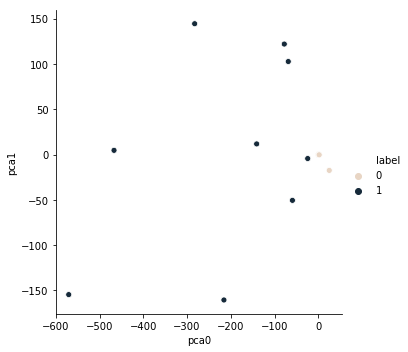

In [39]:
cmap = sns.cubehelix_palette(n_colors=2, rot=-0.7)
sns.relplot(x='pca0', y='pca1', hue='label', data=viz, palette=cmap)

Although the plot utiizes only the first two components, which combine to explain less than half of the variance, and a few points are not individually visible since they are too close together, even here the clusters can be seen to comprise a large group occupying most of the plot and a group of outliers. With the exception of EvanSinar, the outlying cluster groups together people who included zero or very few hashtags and mentions common to others in their tweets.

In [40]:
viz['num_entities'] = [sum(list(entities.iloc[ix])) for ix, name in enumerate(names)]

viz.sort_values(by='num_entities')

,pca0,pca1,label,num_entities
analyticbridge,0.307586,0.012970,0,0
naval,0.307586,0.012970,0,0
mrogati,1.428811,-0.320550,0,4
hmason,1.750313,-0.344222,0,5
AndrewYNg,0.388220,-0.462557,0,6
data_nerd,-24.461976,-4.433887,1,147
kdnuggets,-59.388896,-50.623356,1,265
craigbrownphd,-77.941819,121.987721,1,563
tamaradull,-68.869570,102.686163,1,573
EvanSinar,24.740672,-17.542021,0,665


The optimal KMeans grouping scheme of 2 clusters divides the authors into a group with very few common hashtags and mentions, and another group comprising authors with many common hashtags and mentions. EvanSinar is the exception, having 665 common hashtags and mentions but appearing in the group with very few of these. This might represent one network comprising 9 members and 6 people whose networks do not intersect with each other or those in the 9-member group, but the few-entities group also might comprise mostly authors whose style is to not use many hashtags or mentions. It would be interesting to look at the 6-cluster groupings, but this question cannot be settled given the data. Without all of the authors using a good number of common hashtags and/or mentions, clustering on these features will not produce useful results. Clustering on only those authors who do use large numbers of these entities could produce insights.

### Try spectral clustering

In [41]:
sc = SpectralClustering(n_clusters=4)
sc.fit(entities)

sc_labels = sc.labels_
sc_labels

/Users/vince/anaconda/envs/thinkful/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


array([0, 2, 3, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0], dtype=int32)

The warning arises from the fact that two of the authors have entity vectors that are all zeroes. This results in the graph being not fully connected. Forcing the algorithm to create four clusters produces one large cluster, two 2-person clusters and a 1-person cluster. At this point, the reults taken together indicate that clustering on the hashtags and mentions is not very useful.

## Try clustering using tf-idf vectorization

In [42]:
import re

In [43]:
# gather the tweet texts as elements of a list in preparation for tf-idf vectorization
# create a dataframe with a list for each author, for clustering, and one with indidvidual tweets and their authors

tweet_texts = []
tweet_authors = []
tweets_by_author = pd.DataFrame(index=names, columns=['combined'])


for name in names:
    tweets = [re.sub('https?:\/\/[-\w.]\.?[a-zA-Z0-9]+\/?[a-zA-Z0-9]*', '', tweet.text).strip()
              for tweet in all_tweets[name]]
    tweets_by_author.loc[name, 'combined'] = ' '.join(tweets)
    tweet_texts.extend(tweets)
    tweet_authors.extend([name] * len(tweets))
        

In [45]:
tweets_df = pd.DataFrame({'text': tweet_texts, 'author': tweet_authors})

In [46]:
# reality check: the tweets in the dataframe should change authors at a multiple of 500

tweets_df.loc[995:1005]

,author,text
995,Ronald_vanLoon,Six Ways #CIOs Can Drive #DigitalTransformatio...
996,Ronald_vanLoon,#SmartManufacturing clearly explained in 2 min...
997,Ronald_vanLoon,Knowing the Difference between #UX and #UI Des...
998,Ronald_vanLoon,QIN #AI Phone on MioT Crowdfunding Platform\nb...
999,Ronald_vanLoon,#MachineLearning Summarized in One Picture\nby...
1000,craigbrownphd,"Augmented reality, fog, and vision: Duke profe..."
1001,craigbrownphd,Openreach extends full-fibre broadband roll-ou...
1002,craigbrownphd,"After Fetching a High Price, Time Magazine Mov..."
1003,craigbrownphd,A Piece of Christmas Pie: The most criticized ...
1004,craigbrownphd,Full-fibre broadband penetration reaches 5% #...


Apply tf-idf vectorization. Tweets are compact and rely on impact words more than grammatical constructions, so vocabulary seems more appropriate than tokenization and analysis involving parts of speech and phraseology. A question to be settled is whether individual tweets are too short to produce meaningful vectorizations, in which case groupings of several tweets might produce better results.

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [48]:
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [50]:
auth_vectors = vectorizer.fit_transform(tweets_by_author['combined'])
terms = vectorizer.get_feature_names()
cluster_df = pd.DataFrame(auth_vectors.toarray(), index=names, columns=terms)

## Re-run the clustering algorithms on the vectorized combined tweets

In [215]:
ms.fit(normalize(cluster_df))
ms.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [216]:
clusters = []
cluster_data = normalize(cluster_df)
for _ in range(1000):
    best_score = -999
    num_labels = 0
    for num_clusters in range(5, 10):
        km = KMeans(num_clusters)
        km.fit(cluster_data)
        sil_score = silhouette_score(cluster_data, km.labels_)
        if sil_score > best_score:
            best_score = sil_score
            num_labels = num_clusters
    clusters.append(num_labels)

optimal_num_clusters = Counter(clusters).most_common(1)[0][0]
print(Counter(clusters).most_common())
print('The optimal number of clusters is {}'.format(optimal_num_clusters))
      
best_labels1 = []
best_score1 = -999
centers1 = []

for _ in range(1000):
    km = KMeans(optimal_num_clusters)
    km.fit(cluster_data)
    sil_score = silhouette_score(cluster_data, km.labels_)
    if sil_score > best_score1:
        best_score1 = sil_score
        best_labels1 = km.labels_
        centers1 = km.cluster_centers_

for i in range(optimal_num_clusters):
    print('Cluster {} comprises {}'.format(i, [name for ix, name in enumerate(names) if best_labels1[ix] == i]))

[(7, 316), (8, 260), (6, 250), (5, 153), (9, 21)]
The optimal number of clusters is 7
Cluster 0 comprises ['analyticbridge']
Cluster 1 comprises ['AndrewYNg', 'mrogati', 'naval', 'hmason']
Cluster 2 comprises ['BernardMarr', 'EvanSinar']
Cluster 3 comprises ['KirkDBorne', 'Ronald_vanLoon', 'kdnuggets']
Cluster 4 comprises ['BigDataGal']
Cluster 5 comprises ['bobehayes', 'data_nerd']
Cluster 6 comprises ['craigbrownphd', 'tamaradull']


In [217]:
# reduce feature space to 5 principal components and choose two with the greatest spread among authors for graphing
svd = TruncatedSVD(5)
cluster_lsa = svd.fit_transform(cluster_data)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components: ", total_variance*100)

authors_by_component = pd.DataFrame(cluster_lsa, index=names)
for i in range(5):
    print('Component {}:'.format(i))
    print(authors_by_component.loc[:,i].sort_values(ascending=False)[0:15])

Percent variance captured by all components:  37.0065018534
Component 0:
kdnuggets         0.491304
BernardMarr       0.470505
KirkDBorne        0.469460
AndrewYNg         0.453781
data_nerd         0.440996
hmason            0.427634
mrogati           0.426190
tamaradull        0.400840
bobehayes         0.358837
naval             0.347496
craigbrownphd     0.290169
analyticbridge    0.278764
Ronald_vanLoon    0.249605
BigDataGal        0.244293
EvanSinar         0.228506
Name: 0, dtype: float64
Component 1:
KirkDBorne        0.576047
kdnuggets         0.497440
Ronald_vanLoon    0.274920
bobehayes         0.201742
BernardMarr       0.175465
analyticbridge    0.125532
EvanSinar         0.107659
BigDataGal       -0.055732
craigbrownphd    -0.079084
data_nerd        -0.137469
tamaradull       -0.164458
AndrewYNg        -0.264794
naval            -0.352711
mrogati          -0.444565
hmason           -0.473981
Name: 1, dtype: float64
Component 2:
bobehayes         0.517187
data_nerd       

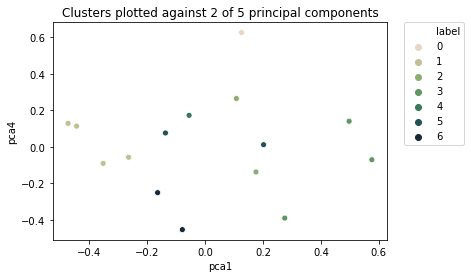

In [218]:
authors_by_component['label'] = best_labels1
cmap = sns.cubehelix_palette(n_colors=7, rot=-0.7)
ax = sns.scatterplot(data=authors_by_component, x=1, y=4, hue='label', palette=cmap)
ax.set_title('Clusters plotted against 2 of 5 principal components')
ax.set_ylabel('pca4')
ax.set_xlabel('pca1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

The clusters are fairly well segregated on a 2-component plot. Look for commonalities in the 10 highest-scoring terms for each author. 

In [219]:
words = cluster_df.T
groupings = pd.DataFrame(index=names, columns=range(10))
for name in names:
    groupings.loc[name, :] = words[name].sort_values(ascending=False)[0:10].index
groupings['label'] = best_labels1
groupings.sort_values(by='label')

,0,1,2,3,4,5,6,7,8,9,label
analyticbridge,conventional,statistical,posted,blogs,excel,cheat,logistic,qualitative,classification,comparison,0
AndrewYNg,coursera,dl,stanford,conversational,moocs,nice,gpus,lets,nips2016,goodfellow_ian,1
mrogati,chrisalbon,peteskomoroch,congratulations,dtunkelang,arnicas,oh,deck,caitie,imo,hmason,1
naval,meditation,crypto,thread,listen,peace,awareness,investors,desire,meetings,moment,1
hmason,cloudera,fastforwardlabs,congratulations,happy,nyc,lol,mikeloukides,favorite,junior,amuellerml,1
BernardMarr,odsc,london,19th,keynote,speaker,leadership,talend,19,tickets,summit,2
EvanSinar,dataviz,leadership,hr,hranalytics,kdnuggets,storywithdata,central,visualizing,flowingdata,workplace,2
KirkDBorne,datascientists,deeplearning,odsc,neuralnetworks,predictiveanalytics,coding,boozallen,west,rstats,datasciencectrl,3
Ronald_vanLoon,rt,cc,dl,deeplearning,digitaltransformation,internetofthings,infographics,videos,smartcity,iiot,3
kdnuggets,deeplearning,sep,cheat,kdnuggets,biases,odsc,scratch,sheet,datascientists,sheets,3


It's hard to see much in common among the members of each cluster, but both members of cluster 2 talk about leadership. All three authors in cluster 3 highlight deep learning, and the two cluster 6 autors have a shared interest in 5g and applied tech in general.  The other groups have no obvious commonalities among members (clusters 1 and 5) or are individuals (clusters 0 and 4).

Look for words closest to the centroid of each cluster that score as high-impact words for cluster members, and see which of these words all members have in common.

In [222]:
centroids1 = centers1.argsort()[:, ::-1] 
words_df = pd.DataFrame(cluster_data, index=names, columns=terms)
print('High-impact words close to the centroid and common to all members in each cluster\n\n')
for i in range(optimal_num_clusters):
    print('Cluster {}:'.format(i))
    people = [name for name in names if groupings.loc[name, 'label'] == i]
    words = []
    for ind in centroids1[i]:
        word = terms[ind]
        common = True
        for person in people:
            if words_df.loc[person, word] <= 0.03: # the .03 threshold was obtained by trying various values
                common = False
                break
        if common == True:
            words.append(word)
        if len(words) == 20:
            break
    print('\n', words, '\n\n')

High-impact words close to the centroid and common to all members in each cluster


Cluster 0:

 ['conventional', 'statistical', 'posted', 'blogs', 'excel', 'cheat', 'logistic', 'qualitative', 'classification', 'comparison', 'sheet', 'trees', 'handbook', 'shiny', 'apache', 'linear', 'mistakes', 'simplified', 'tests', 'clustering'] 


Cluster 1:

 ['favorite', 'tweet', 'maybe'] 


Cluster 2:

 ['leadership', 'workplace'] 


Cluster 3:

 ['deeplearning', 'neuralnetworks'] 


Cluster 4:

 ['womenintech', 'callforcode', 'keyboard', 'coding', 'professional', 'biz', 'clarify', 'portfolio', 'tag', 'exec', 'sponsor', 'shirts', 'retro', 'greatly', '22', 'enter', 'dummies', 'incl', 'celebrate', 'ya'] 


Cluster 5:

 ['ibmanalytics', 'tmanspeaks', 'thecube', 'winwithai', 'psb_dc', 'datachick', 'kevin_jackson', 'cspenn', 'sardire', 'ht', 'mclynd', 'nyc', 'angelalipscomb', 'womenintech', 'majority'] 


Cluster 6:

 ['5g', 'announced', 'edgecomputing', 'oracle', 'private'] 




This programmatic analysis of the intra-group comonalities confirms and expands the insights from visual inspection of the top 10 words for each author.
- Clusters 0 and 4, individuals, have large numbers of words, because neither has another person to filter for common words.
- The words from cluster 1 words reveal no common topic of interest, but these are the authors who used few or no hashtags and mentions. So there is a logic to the grouping.
- The cluster 2 authors both used the terms 'leadership' and 'workplace,' showing perhaps a shared interest in management.
- For cluster 3, the authors had 'neuralnetworks' as well as 'deeplearning' in common, strengthening the topical bond.
- There is a surprise in that the cluster 5 authors share many terms in common. Rather than topics, however, they seem to comprise mostly mentions and groups, suggesting these authors have overlapping work and/or social networks.
- The cluster 6 authors shared 'edgecomputing' as well as '5g,' but also 'oracle,' enterprise software. These seem to suggest an applications-oriented focus.

*__It should be noted__*, however, that a number of the common influential "words" are joined phrases, indicating that they likely were hashtags (or mentions). This contaminates the results, since, for instance, any number of authors might have written about 'deep learning,' even to the point where 'deep' and 'learning' on their own ended up with very low scores, or maybe were even excluded because they occurred too frequently. This seems an intractable problem with the tf-idf approach employed. A bag-of-words approach would have the converse problem. 

The thematic topic(s) of each cluster can be analyzed by looking at the terms closest to its centroid, regardless of which members used those terms or had them in common.

In [221]:
print('Words closest to the centroid of each cluster\n\n')
for i in range(optimal_num_clusters):
    print('Cluster {}:'.format(i))
    words = [terms[ind] for ind in centroids1[i][:10]]
    print(words, '\n\n')

Words closest to the centroid of each cluster


Cluster 0:
['conventional', 'statistical', 'posted', 'blogs', 'excel', 'cheat', 'logistic', 'qualitative', 'classification', 'comparison'] 


Cluster 1:
['congratulations', 'chrisalbon', 'coursera', 'cloudera', 'happy', 'peteskomoroch', 'fastforwardlabs', 'stanford', 'favorite', 'dl'] 


Cluster 2:
['leadership', 'dataviz', 'odsc', 'london', 'hr', '19th', 'keynote', 'speaker', 'hranalytics', 'workplace'] 


Cluster 3:
['deeplearning', 'datascientists', 'rt', 'cc', 'odsc', 'neuralnetworks', 'sep', 'cheat', 'digitaltransformation', 'kdnuggets'] 


Cluster 4:
['womenintech', 'callforcode', 'keyboard', 'coding', 'professional', 'biz', 'clarify', 'portfolio', 'tag', 'exec'] 


Cluster 5:
['customerexperience', 'ibmanalytics', 'tmanspeaks', 'thecube', 'winwithai', 'psb_dc', 'sassoftware', 'analyticsx', 'callforcode', 'datachick'] 


Cluster 6:
['huawei', '5g', 'nytimes', 'techrepublic', 'emergingtech', 'forbes', 'api', 'sassoftware', 'devops', 

These results solidify the already established themes. Cluster 2 has 'hr' and 'hranalytics,' in addition to 'leadership' and 'workplace,' further emphasizing management concerns, but it also has 'odsc,' 'london,' '19,' 'keynote' and 'speaker,' suggesting the two authors in this group were strongly involved with the ODSC Europe conference held Sept. 19-22 this year in London. gains a sharper enterprise focus with the addition of 'sassoftware,' 'devops' and 'dataanalytics.' For cluster 3, 'datascientists,' 'digitaltransformation' and 'kdnuggets' extend the AI/machine learning emphasis of deep learning and neural networks. Similarly, 'emergingtech,' 'sassoftware,' 'dataanalytics' and 'devops' fit with the cluster 6 emphasis on applied data sciece and emerging technologies. The fact that there is little overlap between the central terms of clusters 1 and 5 and the high-scoring terms, respectively, of their members supports the idea that the connections here have more to do with things beside topical content — low use of hashtags and mentions for cluster 1 and network relationships for cluster 5. 

In [214]:
sc = SpectralClustering(n_clusters=optimal_num_clusters)

best_score = -999
best_sc_labels = []
for _ in range(1000):
    sc.fit(cluster_data)
    sil_score = silhouette_score(cluster_data, sc.labels_)
    if sil_score > best_score:
        best_score = sil_score
        best_sc_labels = sc.labels_


print(sc_labels, '\n')
for i in range(7):
    print('Cluster {} comprises {}'.format(i, [name for ix, name in enumerate(names) if sc_labels[ix] == i]))

[0 2 3 0 0 0 0 0 0 0 1 1 2 0 0] 

Cluster 0 comprises ['KirkDBorne', 'bobehayes', 'BernardMarr', 'BigDataGal', 'AndrewYNg', 'mrogati', 'data_nerd', 'kdnuggets', 'hmason', 'EvanSinar']
Cluster 1 comprises ['analyticbridge', 'naval']
Cluster 2 comprises ['Ronald_vanLoon', 'tamaradull']
Cluster 3 comprises ['craigbrownphd']
Cluster 4 comprises []
Cluster 5 comprises []
Cluster 6 comprises []


These results are not as observably coherent as those from K-Means.

## Classification

In [62]:
X_train, X_test, y_train, y_test = train_test_split(tweets_df['text'], tweets_df['author'], test_size=0.4,
                                                    random_state=0, stratify=tweets_df['author'])


# apply the vectorizer, but don't fit on the test set to prevent data leakage
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [63]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

mcc_scorer = make_scorer(matthews_corrcoef)

Evaluate performance with cross-validation scoring of the basic estimators, using the Matthews correlation coefficient, which uses all the metrics from the confusion matrix. See if classification into clusters (7 classes) produces significantly better results thn classifying by individual authors (15 classes).

In [64]:
rfc = RandomForestClassifier(max_depth=20)

print(cross_val_score(rfc, X_train_tfidf, y_train, scoring=mcc_scorer, cv=4))

[ 0.46234669  0.50964209  0.49930392  0.49227999]


In [65]:
rfc.fit(X_train_tfidf, y_train)
print(matthews_corrcoef(y_test, rfc.predict(X_test_tfidf)))

0.525515126777


In [67]:
# create cluster targets

groupings = dict(zip(names, best_labels))
y_groupings_train = y_train.apply(lambda x: groupings[x])
y_groupings_test = y_test.apply(lambda x: groupings[x])

In [68]:
print(cross_val_score(rfc, X_train_tfidf, y_groupings_train, scoring=mcc_scorer, cv=4))

[ 0.5606641   0.52582477  0.56111559  0.57701059]


In [69]:
gbc = GradientBoostingClassifier()

print(cross_val_score(gbc, X_train_tfidf, y_train, scoring=mcc_scorer, cv=4))

[ 0.60347114  0.62307522  0.59202515  0.62965837]


In [70]:
print(cross_val_score(gbc, X_train_tfidf, y_groupings_train, scoring=mcc_scorer, cv=4))

[ 0.66994175  0.665331    0.67909601  0.68573099]


In [71]:
lrc = LogisticRegression()

print(cross_val_score(lrc, X_train_tfidf, y_train, scoring=mcc_scorer, cv=4))

[ 0.63869872  0.64720024  0.64028847  0.66333377]


In [72]:
print(cross_val_score(lrc, X_train_tfidf, y_groupings_train, scoring=mcc_scorer, cv=4))

[ 0.65598059  0.65292284  0.63555165  0.66805898]


In [75]:
knc = KNeighborsClassifier(n_neighbors=10)

print(cross_val_score(knc, X_train_tfidf, y_train, scoring=mcc_scorer, cv=4))

[ 0.10898367  0.11756348  0.09299779  0.08517069]


In [78]:
ada_rf = AdaBoostClassifier(rfc)

print(cross_val_score(ada_rf, X_train_tfidf, y_train, scoring=mcc_scorer, cv=4))

[ 0.5515781   0.53595922  0.52707939  0.54555063]


In [79]:
ada_lr = AdaBoostClassifier(lrc)
print(cross_val_score(ada_lr, X_train_tfidf, y_train, scoring=mcc_scorer, cv=4))

[ 0.58022999  0.59000165  0.58090456  0.60682544]


Using cluster labels instead of individuals as the targets did not significantly improve the results, despite reducing the number of classes by half. The one exception to this was with gradient boosting, where the score increased by about 10%. Gradient boosting also had the highest score on the 15-label (individual) classification. But does it overfit?

In [80]:
gbc.fit(X_train_tfidf, y_train)
print(matthews_corrcoef(y_test, gbc.predict(X_test_tfidf)))

0.637056642137


In [81]:
gbc.fit(X_train_tfidf, y_groupings_train)
print(matthews_corrcoef(y_groupings_test, gbc.predict(X_test_tfidf)))

0.699756882177


See if lemmatizing the tweets improves performance

In [82]:
import spacy
nlp = spacy.load('en_core_web_md')

In [83]:
def tokenize(input):
    tokens = nlp(input)
    output = [token.lemma_ for token in tokens
              if token.lemma_ not in ['#', ",'", ',"', ".'", '."', "?'", '?"']
              and not (token.is_punct and len(token.lemma_) == 1) # keep two-character emoticons, e.g. :) or ;) 
              and not token.is_stop]
    return ' '.join(output).strip()

In [84]:
X_train_tokenized = X_train.apply(tokenize)
X_test_tokenized = X_test.apply(tokenize)

In [85]:
X_train_tok_tfidf = vectorizer.fit_transform(X_train_tokenized)
X_test_tok_tfidf = vectorizer.transform(X_test_tokenized)

In [86]:
print(cross_val_score(lrc, X_train_tok_tfidf, y_train, scoring=mcc_scorer, cv=4))

[ 0.63302328  0.63978736  0.65983682  0.66226785]


In [87]:
print(cross_val_score(lrc, X_train_tok_tfidf, y_groupings_train, scoring=mcc_scorer, cv=4))

[ 0.65210307  0.66424054  0.64047843  0.69511199]


In [88]:
print(cross_val_score(gbc, X_train_tok_tfidf, y_train, scoring=mcc_scorer, cv=4))

[ 0.61004454  0.59668689  0.57822303  0.63477301]


In [89]:
print(cross_val_score(gbc, X_train_tok_tfidf, y_groupings_train, scoring=mcc_scorer, cv=4))

[ 0.6629701   0.65984947  0.6777627   0.68588167]


No significant improvement, and the cross-eval scores for gradient boosting are a little less consistent. See if adding bigrams improves performance.

In [90]:
len(terms)

4506

In [91]:
vectorizer2 = TfidfVectorizer(ngram_range=(1,2), 
                              max_df=0.5, # drop words that occur in more than half the paragraphs
                              min_df=2, # only use words that appear at least twice
                              max_features=6000, # increase to ensure that at least the 1,500 highest-scoring bigrams are used
                              stop_words='english', 
                              lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                              use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                              norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                              smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                             )

In [92]:
X_train_tfidf2 = vectorizer2.fit_transform(X_train)
X_test_tfidf2 = vectorizer2.transform(X_test)

In [93]:
print(cross_val_score(lrc, X_train_tfidf2, y_train, scoring=mcc_scorer, cv=4))

[ 0.63745287  0.64613577  0.64399704  0.66797534]


In [94]:
print(cross_val_score(lrc, X_train_tfidf2, y_groupings_train, scoring=mcc_scorer, cv=4))

[ 0.66487708  0.66872642  0.65288231  0.6764393 ]


Neither tokenization nor adding bigrams significantly improved performance, so tune the hyperparameters for logistic regression on the basic tf-idf data.

In [95]:
lrc_params = [{'penalty': ['l1', 'l2'], 'tol': [1e-4, 1e-3, 1e-2], 'C': [3, 5, 7, 10],
               'solver': ['liblinear'], 'multi_class': ['ovr']},
              { 'penalty': ['l2'], 'tol': [1e-4, 1e-3, 1e-2], 'C': [3, 5, 7, 10],
               'solver': ['newton-cg', 'lbfgs'], 'multi_class': ['ovr', 'multinomial']}]

In [96]:
from sklearn.model_selection import GridSearchCV

In [97]:
def optimize(rand, X=tweets_df['text'], Y=tweets_df['author'], transformer=None,
             clf=lrc, params=lrc_params, t_size=0.4):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=t_size, random_state=rand, stratify=Y)
    if transformer:
        X_train = transformer.fit_transform(X_train)
        X_test = transformer.transform(X_test)
    model = GridSearchCV(clf, param_grid=params, scoring=mcc_scorer)
    model.fit(X_train, Y_train)
    print('Optimal parameters: {}'.format(model.best_params_))
    preds = model.predict(X_test)
    print('Matthews score: {}'.format(matthews_corrcoef(Y_test, preds)))
    # The following three lines would need to be modified to apply to a multi-class setting
    # print('ROC-AUC score: {}'.format(roc_auc_score(Y_test, preds)))
    # residuals = pd.DataFrame(model.best_estimator_.decision_function(Xr_test))
    # plt.scatter(residuals.index, residuals)
    return model

In [98]:
opt1 = optimize(rand=7, transformer=vectorizer)

Optimal parameters: {'C': 5, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.01}
Matthews score: 0.6895957737101615


In [99]:
opt2 = optimize(rand=29, transformer=vectorizer)

Optimal parameters: {'C': 5, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.01}
Matthews score: 0.6856909270155424


In [100]:
opt1 = optimize(rand=41, transformer=vectorizer)

Optimal parameters: {'C': 7, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.01}
Matthews score: 0.6730672687972501


The model seems relatively stable. Further tweaking could probably nail down the optimal C value between 4 and 5, and the tolerance between .oo1 and .0001, but the optimation consistently selected the liblinear solver with the L2 penalty and the one-vs-rest multi-class strategy. The model woul correctly assign the author of the tweet (among the 15 authors)

In [101]:
opt1 = optimize(rand=7, transformer=vectorizer, t_size=0.35)

Optimal parameters: {'C': 7, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.01}
Matthews score: 0.6941464651260699


In [102]:
opt1 = optimize(rand=7, transformer=vectorizer, t_size=0.3)

Optimal parameters: {'C': 3, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}
Matthews score: 0.6931456101358475


The model is not overly sensitive to the relative sizes of the train/test split, although both 65/35 (best score) and 70/30 perform slightly better than 60/40. The decrease in the C parameter on the 70/30 split, however, might indicate that the model is starting to overfit, with larger regression coefficients.

Try clustering again, adding bigrams into the tf-idf vector features. 

In [106]:
auth_vectors2 = vectorizer2.fit_transform(tweets_by_author['combined'])
terms2 = vectorizer2.get_feature_names()
cluster_df2 = pd.DataFrame(auth_vectors2.toarray(), index=names, columns=terms2)

clusters = []
cluster_data2 = normalize(cluster_df2)
for _ in range(1000):
    best_score = -999
    num_labels = 0
    for num_clusters in range(5, 10):
        km = KMeans(num_clusters)
        km.fit(cluster_data2)
        sil_score = silhouette_score(cluster_data2, km.labels_)
        if sil_score > best_score:
            best_score = sil_score
            num_labels = num_clusters
    clusters.append(num_labels)

optimal_num_clusters = Counter(clusters).most_common(1)[0][0]
print(Counter(clusters).most_common())
print('The optimal number of clusters is {}'.format(optimal_num_clusters))
      
best_labels = []
best_score = -999

for _ in range(1000):
    km = KMeans(optimal_num_clusters)
    km.fit(cluster_data2)
    sil_score = silhouette_score(cluster_data2, km.labels_)
    if sil_score > best_score:
        best_score = sil_score
        best_labels = km.labels_

for i in range(optimal_num_clusters):
    print('Cluster {} comprises {}'.format(i, [name for ix, name in enumerate(names) if best_labels[ix] == i]))

[(6, 330), (7, 225), (5, 220), (8, 129), (9, 96)]
The optimal number of clusters is 6
Cluster 0 comprises ['bobehayes', 'data_nerd']
Cluster 1 comprises ['AndrewYNg', 'mrogati', 'naval', 'hmason']
Cluster 2 comprises ['KirkDBorne', 'Ronald_vanLoon', 'kdnuggets', 'analyticbridge']
Cluster 3 comprises ['craigbrownphd', 'tamaradull']
Cluster 4 comprises ['BigDataGal']
Cluster 5 comprises ['BernardMarr', 'EvanSinar']


One of the individuals has been brought into the 'deep learning' group.

One last variation will be to match hashtags to concatenated bigrams, and add as many bigrams as matches to the combined tweets for each author. This will allow similarity measures to factor in matches between the bigram and hashtag variants of common two-word phrases, such as 'deep learning,' across authors. This will be used only for clustering, though, since hashtags vs. bigrams is a useful difference for classifiction purposes. It is expected that this could result in fewer, larger clusters by generating larger similarity scores between authors. 

In [108]:
vectorizer3 = TfidfVectorizer(ngram_range=(2,2), 
                              max_df=0.5, # drop words that occur in more than half the paragraphs
                              min_df=2, # only use words that appear at least twice
                              stop_words='english', 
                              lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                              use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                              norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                              smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                             )

In [142]:
vectorizer3.fit_transform(tweets_by_author['combined'])
bigrams = vectorizer3.get_feature_names()

In [143]:
# add the bigrams

def expand(author):
    addition = []
    for bigram in bigrams:
        num_tags = all_tags[author][bigram.replace(' ', '')]
        if num_tags:
            addition.extend([bigram] * num_tags)
    return ' ' + ' '.join(addition)

In [146]:
transfer = pd.DataFrame(index=names, columns=['extended'])
for name in names:
    transfer.loc[name, 'extended'] = tweets_by_author.loc[name, 'combined'] + expand(name)

In [147]:
auth_vectors3 = vectorizer2.fit_transform(transfer['extended'])
terms3 = vectorizer2.get_feature_names()
cluster_df3 = pd.DataFrame(auth_vectors3.toarray(), index=names, columns=terms3)

In [202]:
clusters = []
cluster_data3 = normalize(cluster_df3)
for _ in range(1000):
    best_score = -999
    num_labels = 0
    for num_clusters in range(3, 8):
        km = KMeans(num_clusters)
        km.fit(cluster_data3)
        sil_score = silhouette_score(cluster_data3, km.labels_)
        if sil_score > best_score:
            best_score = sil_score
            num_labels = num_clusters
    clusters.append(num_labels)

optimal_num_clusters = Counter(clusters).most_common(1)[0][0]
print(Counter(clusters).most_common())
print('The optimal number of clusters is {}'.format(optimal_num_clusters))
      
best_labels3 = []
best_score3 = -999
centers3 = []

for _ in range(1000):
    km = KMeans(optimal_num_clusters)
    km.fit(cluster_data3)
    sil_score = silhouette_score(cluster_data3, km.labels_)
    if sil_score > best_score3:
        best_score3 = sil_score
        best_labels3 = km.labels_
        centers3 = km.cluster_centers_

for i in range(optimal_num_clusters):
    print('Cluster {} comprises {}'.format(i, [name for ix, name in enumerate(names) if best_labels3[ix] == i]))

[(5, 339), (6, 335), (4, 197), (7, 121), (3, 8)]
The optimal number of clusters is 5
Cluster 0 comprises ['KirkDBorne', 'Ronald_vanLoon', 'BernardMarr', 'kdnuggets', 'analyticbridge']
Cluster 1 comprises ['AndrewYNg', 'mrogati', 'naval', 'hmason']
Cluster 2 comprises ['bobehayes', 'data_nerd']
Cluster 3 comprises ['EvanSinar']
Cluster 4 comprises ['craigbrownphd', 'BigDataGal', 'tamaradull']


This technique produces the most compact clustering. The number of clusters has come down to 5, with the other former individual joining the group that seems to be based on network connections. But EvanSinar, who despite using more than 600 hashtags and mentions initially was put in with the group that used few or none of these entities, now is grouped as an individual. This would support a hypothesis that this author used entities not used by the other authors, since "double counting" these as bigrams would isolate this person from both those that used more common entities and those that used few or none. It appears that hashtags and mentions dominated the clustering even when the full tweet texts were used.

In [232]:
centroids3 = centers3.argsort()[:, ::-1]
words_df3 = pd.DataFrame(cluster_data3, index=names, columns=terms3)
groupings3 = dict(zip(names, best_labels3))
print('High-impact words close to the centroid and common to all members in each cluster\n\n')
for i in range(optimal_num_clusters):
    print('Cluster {}:'.format(i))
    people = [name for name in names if groupings3[name] == i]
    words = []
    for ind in centroids3[i]:
        word = terms3[ind]
        common = True
        for person in people:
            if words_df3.loc[person, word] <= 0.001: # threshold lowered to produce results for cluster 0
                common = False
                break
        if common == True:
            words.append(word)
        if len(words) == 20:
            break
    print('\n', words, '\n\n')

High-impact words close to the centroid and common to all members in each cluster


Cluster 0:

 ['neural network', 'ebook'] 


Cluster 1:

 ['happy', 'favorite', 'tweet', 'sorry', 'thread', 'enjoy', 'maybe', 'hour', 'outside', 'looking forward', 'wouldn', 'disagree', 'english', 'saying', 'imagine', 'couldn', 'beautiful', 'invest', 'easily', 'wish'] 


Cluster 2:

 ['ibmanalytics', 'tmanspeaks', 'machinelearning datascience', 'thecube', 'psb_dc', 'winwithai', 'datachick', 'analyticsx', 'kevin_jackson', 'cspenn', 'callforcode', 'siliconangle', 'sardire', 'ht', 'mclynd', 'nyc', 'customer experience', 'ibmanalytics ibm', 'loyalty', 'womenintech'] 


Cluster 3:

 ['viz data', 'data viz', 'viz', 'dataviz', 'leadership', 'hr', 'hranalytics', 'kdnuggets', 'data visualization', 'storywithdata', 'kdnuggets datascience', 'central', 'visualizing', 'flowingdata', 'workplace', 'forecast', 'storytelling', 'futureofwork', 'harvardbiz', 'quartz'] 


Cluster 4:

 ['ai iot', 'iot bigdata', '5g', 'bigdat

As the clusters grow larger, it is more difficult to find terms that all members have in common. But the terms closest to the cluster centers would still sketch common themes.

In [225]:
print('Words closest to the centroid of each cluster\n\n')
for i in range(optimal_num_clusters):
    print('Cluster {}:'.format(i))
    words = [terms3[ind] for ind in centroids3[i][:10]]
    print(words, '\n\n')

Words closest to the centroid of each cluster


Cluster 0:
['deeplearning', 'rt', 'odsc', 'datascientists', 'cc', 'join learn', 'conventional', 'cheat', 'accelerate ai', 'datascience machinelearning'] 


Cluster 1:
['congratulations', 'chrisalbon', 'cloudera', 'coursera', 'happy', 'peteskomoroch', 'fastforwardlabs', 'favorite', 'stanford', 'tweet'] 


Cluster 2:
['artificialintelligence machinelearning', 'ibmanalytics', 'customerexperience', 'tmanspeaks', 'machinelearning datascience', 'thecube', 'psb_dc', 'winwithai', 'datachick', 'analyticsx'] 


Cluster 3:
['viz data', 'data viz', 'viz', 'dataviz', 'leadership', 'hr', 'hranalytics', 'kdnuggets', 'data visualization', 'storywithdata'] 


Cluster 4:
['huawei', 'ai iot', 'iot bigdata', '5g', 'nytimes', 'bigdata automation', 'ai datascience', 'womenintech', 'datascience bigdata', 'techrepublic'] 




The former group that seemed to highlight management concerns but also might have had a stronger connection to the ODSC Europe conference has disappeared, with both members now assigned to other clusters. The largest now is the AI/machine learning group, cluster 0, comprising KirkDBorne, Ronald_vanLoon, BernardMarr, kdnuggets and analyticbridge. Next comes the cluster 1 group of four authors — AndrewYNg, mrogati, naval, hmason — who used few or no hashtags and mentions. The emerging technology group, cluster 4, now has three members: craigbrownphd, BigDataGal and tamaradull. Interestingly, cluster 2, the two authors seemingly grouped together via networking — bobehayes and data_nerd — now has some strong thematic content having to do with machine learning and AI. But it remains separate. Also interesting is that cluster 3, the only remaining group of one, EvanSinar, has an especially tight focus on data stories and visualization.

In [233]:
best_score1

0.039678490663841451

In [234]:
best_score3

0.031624647864379983

Besides its tighter thematic ties, this final 5-cluster grouping has a silhouette score of .032, which is 25% lower than the .040 score of the 7-cluster grouping based on the initial tf=idf vectorization of the tweet texts.